In [30]:
import pandas_datareader.data as web
import pandas as pd
from datetime import datetime, timedelta
from IPython.display import Math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import scipy.optimize as optimize
from numpy import random
import yfinance as yfin

1. Acquiring Data
I selected two sets of five stocks in the tech and oil sectors:
- Tech: AAPL, GOOGL, AMZN, META, MSFT
- Health: ILMN, PFE, HCA, ABMD, ISRG

In [31]:
import fsp_toolkit 

startdate= datetime(year=2017,month=12,day=29)
enddate= datetime(year=2018,month=12,day=31)
#'AAPL'
tech_ticks = ['NVDA', 'GOOGL', 'AMZN', 'META', 'MSFT']
health_ticks = ['ILMN', 'PFE', 'HCA', 'ABMD', 'ISRG']
ticks_not_sp = tech_ticks + health_ticks
ticks = ['^GSPC'] + tech_ticks + health_ticks

stocks = fsp_toolkit.get_stock_data(ticks, startdate, enddate)
stocks.head()

Loaded stocks from pickle


,^GSPC,NVDA,GOOGL,AMZN,META,MSFT,ILMN,PFE,HCA,ABMD,ISRG
Date,,,,,,,,,,,
2018-01-02,0.008303,0.030233,0.018806,0.016708,0.028108,0.004793,0.025356,0.006074,0.019012,0.027106,0.028251
2018-01-03,0.006399,0.065814,0.017061,0.012775,0.017914,0.004654,0.028077,0.007409,-0.027595,0.017300,0.022838
2018-01-04,0.004029,0.005271,0.003884,0.004476,-0.001841,0.008801,0.011593,0.002179,-0.012408,0.017516,-0.017977
2018-01-05,0.007034,0.008474,0.013260,0.016163,0.013671,0.012398,-0.020688,0.001903,0.011284,0.015408,0.005545
2018-01-08,0.001662,0.030641,0.003531,0.014425,0.007653,0.001020,-0.004865,-0.011123,-0.002071,0.027086,0.033904


Now, we use 3-Month US T-Bills as the risk free rate - We divide by 252 the number of trading days - and then filter out non-trading days

In [32]:
enddate= datetime(year=2019,month=1,day=1)

fed_3mo_daily = fsp_toolkit.get_rf_rate(startdate, enddate, 252)
fed_3mo_daily= fed_3mo_daily.loc[stocks.index]

fed_3mo_daily

,3MO T-BILL
Date,
2018-01-02,0.000056
2018-01-03,0.000056
2018-01-04,0.000056
2018-01-05,0.000056
2018-01-08,0.000056
...,...
2018-12-24,0.000094
2018-12-26,0.000094
2018-12-27,0.000094


In [33]:
#Now we substract the risk-free rate from the stock returns to get the excess returns
stocks= stocks.sub(fed_3mo_daily['3MO T-BILL'], axis='rows')
stocks.head()

,^GSPC,NVDA,GOOGL,AMZN,META,MSFT,ILMN,PFE,HCA,ABMD,ISRG
Date,,,,,,,,,,,
2018-01-02,0.008247,0.030177,0.018750,0.016652,0.028052,0.004737,0.025300,0.006018,0.018956,0.027050,0.028195
2018-01-03,0.006343,0.065758,0.017005,0.012719,0.017858,0.004598,0.028021,0.007354,-0.027651,0.017244,0.022782
2018-01-04,0.003973,0.005215,0.003829,0.004420,-0.001897,0.008745,0.011537,0.002123,-0.012464,0.017460,-0.018033
2018-01-05,0.006978,0.008418,0.013204,0.016107,0.013615,0.012342,-0.020744,0.001847,0.011228,0.015352,0.005489
2018-01-08,0.001606,0.030585,0.003475,0.014369,0.007597,0.000965,-0.004921,-0.011179,-0.002127,0.027030,0.033848


First let's work on the full year of data. All returns here are excess returns!

1. (a) Compute the $(\mu; \sigma)$ point for the S&P 500, the expected returns and covariance
matrix for the full set of stocks. By pulling out submatrices, obtain the covariance
matrices of each of the two subsets of stocks (corresponding to each sector).


In [34]:
sp500_mu = stocks['^GSPC'].mean()
sp500_sigma = stocks['^GSPC'].std()

print('The mean of the S&P 500 is ', round(sp500_mu,6), 'and the standard deviation is: ', round(sp500_sigma,6))
stocks.describe(percentiles=[])

The mean of the S&P 500 is  -0.000276 and the standard deviation is:  0.010742


,^GSPC,NVDA,GOOGL,AMZN,META,MSFT,ILMN,PFE,HCA,ABMD,ISRG
count,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000
mean,-0.000276,-0.001061,0.000049,0.001179,-0.000964,0.000766,0.001452,0.000745,0.001443,0.002572,0.001226
std,0.010742,0.030984,0.017765,0.022745,0.023972,0.017823,0.023177,0.012511,0.016264,0.029983,0.021028
min,-0.041042,-0.187651,-0.052864,-0.078286,-0.189687,-0.054427,-0.077527,-0.053053,-0.070443,-0.166220,-0.069267
50%,0.000311,0.000532,0.000058,0.002062,0.000615,0.002173,0.000302,0.001270,0.000644,0.005077,0.001813
max,0.049500,0.093543,0.064070,0.094358,0.090543,0.075638,0.121344,0.047755,0.092100,0.110570,0.081639


In [35]:
cov_all = stocks.cov()
cov_tech = stocks[['^GSPC'] + tech_ticks].cov()
cov_health = stocks[['^GSPC'] + health_ticks ].cov()

covs = {'All': cov_all, 'Tech': cov_tech, 'Health': cov_health}

for cov in covs:
    #Compute Conditional Number
    print("The condition number of the covariance matrix for " + cov + " stocks is: ", round(np.linalg.cond(covs[cov]),6))
    if(round(np.linalg.cond(covs[cov])) > 100):
        print("Numerical stability may be an issue.")
    display(covs[cov].style.bar(color=["#d65f5f", "#5fba7d"], align="mid"))



The condition number of the covariance matrix for All stocks is:  282.755927
Numerical stability may be an issue.


,^GSPC,NVDA,GOOGL,AMZN,META,MSFT,ILMN,PFE,HCA,ABMD,ISRG
^GSPC,0.000115,0.000220,0.000157,0.000187,0.000147,0.000167,0.000183,0.000093,0.000099,0.000184,0.000168
NVDA,0.000220,0.000960,0.000361,0.000451,0.000373,0.000346,0.000431,0.000139,0.000184,0.000478,0.000417
GOOGL,0.000157,0.000361,0.000316,0.000299,0.000267,0.000259,0.000279,0.000099,0.000122,0.000271,0.000275
AMZN,0.000187,0.000451,0.000299,0.000517,0.000316,0.000314,0.000341,0.000119,0.000149,0.000383,0.000345
META,0.000147,0.000373,0.000267,0.000316,0.000575,0.000234,0.000285,0.000081,0.000062,0.000341,0.000266
MSFT,0.000167,0.000346,0.000259,0.000314,0.000234,0.000318,0.000297,0.000123,0.000136,0.000285,0.000280
ILMN,0.000183,0.000431,0.000279,0.000341,0.000285,0.000297,0.000537,0.000133,0.000156,0.000381,0.000335
PFE,0.000093,0.000139,0.000099,0.000119,0.000081,0.000123,0.000133,0.000157,0.000088,0.000095,0.000104
HCA,0.000099,0.000184,0.000122,0.000149,0.000062,0.000136,0.000156,0.000088,0.000265,0.000155,0.000145
ABMD,0.000184,0.000478,0.000271,0.000383,0.000341,0.000285,0.000381,0.000095,0.000155,0.000899,0.000376


The condition number of the covariance matrix for Tech stocks is:  104.105062
Numerical stability may be an issue.


,^GSPC,NVDA,GOOGL,AMZN,META,MSFT
^GSPC,0.000115,0.000220,0.000157,0.000187,0.000147,0.000167
NVDA,0.000220,0.000960,0.000361,0.000451,0.000373,0.000346
GOOGL,0.000157,0.000361,0.000316,0.000299,0.000267,0.000259
AMZN,0.000187,0.000451,0.000299,0.000517,0.000316,0.000314
META,0.000147,0.000373,0.000267,0.000316,0.000575,0.000234
MSFT,0.000167,0.000346,0.000259,0.000314,0.000234,0.000318


The condition number of the covariance matrix for Health stocks is:  79.604857


,^GSPC,ILMN,PFE,HCA,ABMD,ISRG
^GSPC,0.000115,0.000183,0.000093,0.000099,0.000184,0.000168
ILMN,0.000183,0.000537,0.000133,0.000156,0.000381,0.000335
PFE,0.000093,0.000133,0.000157,0.000088,0.000095,0.000104
HCA,0.000099,0.000156,0.000088,0.000265,0.000155,0.000145
ABMD,0.000184,0.000381,0.000095,0.000155,0.000899,0.000376
ISRG,0.000168,0.000335,0.000104,0.000145,0.000376,0.000442


In [36]:
# Compute all the betas

all_ticks = {'All': ticks, 'Tech': tech_ticks, 'Health': health_ticks}
covs = {'All': cov_all, 'Tech': cov_tech, 'Health': cov_health}


for subset in all_ticks:

    print(subset + " stocks:")
    print(all_ticks[subset])

    beta, alpha, residuals= fsp_toolkit.singleFactorModel(stocks, X='^GSPC', Y=all_ticks[subset], cov=covs[subset])
    assert(beta[0] == 1)

    display(pd.DataFrame([alpha, beta], index=['alpha', 'beta'], columns=all_ticks[subset]))
    display(pd.DataFrame(np.cov(residuals.T),columns=all_ticks[subset],index=all_ticks[subset]).style.bar(color=["#d65f5f", "#5fba7d"], align="mid"))



All stocks:
['^GSPC', 'NVDA', 'GOOGL', 'AMZN', 'META', 'MSFT', 'ILMN', 'PFE', 'HCA', 'ABMD', 'ISRG']


,^GSPC,NVDA,GOOGL,AMZN,META,MSFT,ILMN,PFE,HCA,ABMD,ISRG
alpha,0.0,-0.000535,0.000425,0.001626,-0.000612,0.001164,0.001889,0.000966,0.001679,0.003011,0.001628
beta,1.0,1.910066,1.363757,1.623373,1.273976,1.445990,1.586334,0.801640,0.857063,1.593490,1.457889


/home/jacob/miniconda3/lib/python3.9/site-packages/pandas/io/formats/style.py:3777: RuntimeWarning: invalid value encountered in double_scalars
  end = (x - left) / (right - left)


,^GSPC,NVDA,GOOGL,AMZN,META,MSFT,ILMN,PFE,HCA,ABMD,ISRG
^GSPC,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NVDA,0.000000,0.000539,0.000060,0.000094,0.000092,0.000028,0.000081,-0.000038,-0.000005,0.000126,0.000096
GOOGL,0.000000,0.000060,0.000101,0.000044,0.000067,0.000031,0.000030,-0.000027,-0.000013,0.000020,0.000045
AMZN,0.000000,0.000094,0.000044,0.000213,0.000077,0.000043,0.000044,-0.000031,-0.000011,0.000085,0.000071
META,0.000000,0.000092,0.000067,0.000077,0.000387,0.000021,0.000052,-0.000037,-0.000064,0.000107,0.000052
MSFT,0.000000,0.000028,0.000031,0.000043,0.000021,0.000076,0.000032,-0.000011,-0.000007,0.000019,0.000037
ILMN,0.000000,0.000081,0.000030,0.000044,0.000052,0.000032,0.000247,-0.000014,-0.000001,0.000089,0.000068
PFE,0.000000,-0.000038,-0.000027,-0.000031,-0.000037,-0.000011,-0.000014,0.000082,0.000009,-0.000052,-0.000031
HCA,0.000000,-0.000005,-0.000013,-0.000011,-0.000064,-0.000007,-0.000001,0.000009,0.000180,-0.000003,0.000001
ABMD,0.000000,0.000126,0.000020,0.000085,0.000107,0.000019,0.000089,-0.000052,-0.000003,0.000606,0.000108


Tech stocks:
['NVDA', 'GOOGL', 'AMZN', 'META', 'MSFT']


,NVDA,GOOGL,AMZN,META,MSFT
alpha,-0.000535,0.000425,0.001626,-0.000612,0.001164
beta,1.910066,1.363757,1.623373,1.273976,1.445990


,NVDA,GOOGL,AMZN,META,MSFT
NVDA,0.000635,0.000003,0.000121,0.000056,0.000046
GOOGL,0.000003,0.000135,0.000027,0.000089,0.000021
AMZN,0.000121,0.000027,0.000221,0.000067,0.000048
META,0.000056,0.000089,0.000067,0.000401,0.000014
MSFT,0.000046,0.000021,0.000048,0.000014,0.000080


Health stocks:
['ILMN', 'PFE', 'HCA', 'ABMD', 'ISRG']


,ILMN,PFE,HCA,ABMD,ISRG
alpha,0.001889,0.000966,0.001679,0.003011,0.001628
beta,1.586334,0.801640,0.857063,1.593490,1.457889


,ILMN,PFE,HCA,ABMD,ISRG
ILMN,0.000286,-0.000067,0.000003,0.000139,0.000059
PFE,-0.000067,0.000153,0.000004,-0.000119,-0.000018
HCA,0.000003,0.000004,0.000180,0.000002,0.000000
ABMD,0.000139,-0.000119,0.000002,0.000669,0.000096
ISRG,0.000059,-0.000018,0.000000,0.000096,0.000199


You can see that there is a relatively high positive covariance in the top left (ie that tech sector is highly correlated), and PFE and HCA seems to be negatively correlated with the tech sector. However, ABMD, ISRG, and ILMN are positively correlated with tech stocks. They are more biotech oriented, so it make sense. 

In [37]:
# Let's check things with an OLS regression model

import statsmodels.api as sm

# We use the OLS function to estimate the parameters rk = alpha + beta * rm + epsilon
# We use the market as the risk factor
# We use the excess returns of the market as the dependent variable
# We use the excess returns of the stock as the independent variable

X = stocks['^GSPC']
X = sm.add_constant(X)

model = sm.OLS(stocks[tech_ticks[0]], X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   NVDA   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     194.5
Date:                Thu, 27 Oct 2022   Prob (F-statistic):           4.66e-33
Time:                        19:15:00   Log-Likelihood:                 588.84
No. Observations:                 251   AIC:                            -1174.
Df Residuals:                     249   BIC:                            -1167.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.364      0.716      -0.003       0.002
^GSPC          1.9101      0.137     13.946      0.000       1.640       2.180
==============================================================================
Omnibus:                      171.489   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3654.013
Skew:                          -2.318   Prob(JB):                         0.00
Kurtosis:                      21.108   Cond. No.                         93.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The MVP lies on the point ( 0.011056 , 0.000716 ) and the MP lies on the point ( 0.032768 , 0.006289 )


,NVDA,GOOGL,AMZN,META,MSFT,ILMN,PFE,HCA,ABMD,ISRG
Weight of the Min Variance Portfolio,-0.080333,0.193302,-0.060408,0.117272,-0.062550,-0.079494,0.635561,0.260655,0.019347,0.056649
Weight of the Market Portfolio,-0.832273,-0.750233,0.608794,-0.667158,-0.074276,0.485650,0.504189,0.630339,0.599215,0.495753
Mean Expected Returns,-0.001061,0.000049,0.001179,-0.000964,0.000766,0.001452,0.000745,0.001443,0.002572,0.001226


The MVP lies on the point ( 0.016526 , 0.000357 ) and the MP lies on the point ( 0.101 , 0.013346 )


,NVDA,GOOGL,AMZN,META,MSFT
Weight of the Min Variance Portfolio,-0.123375,0.510781,-0.081593,0.135272,0.558915
Weight of the Market Portfolio,-2.473269,-2.220413,4.422758,-2.685482,3.956407
Mean Expected Returns,-0.001061,0.000049,0.001179,-0.000964,0.000766


The MVP lies on the point ( 0.011609 , 0.00096 ) and the MP lies on the point ( 0.015404 , 0.00169 )


,ILMN,PFE,HCA,ABMD,ISRG
Weight of the Min Variance Portfolio,-0.067679,0.703620,0.253408,0.024467,0.086184
Weight of the Market Portfolio,0.009213,0.233876,0.565417,0.336155,-0.144661
Mean Expected Returns,0.001452,0.000745,0.001443,0.002572,0.001226


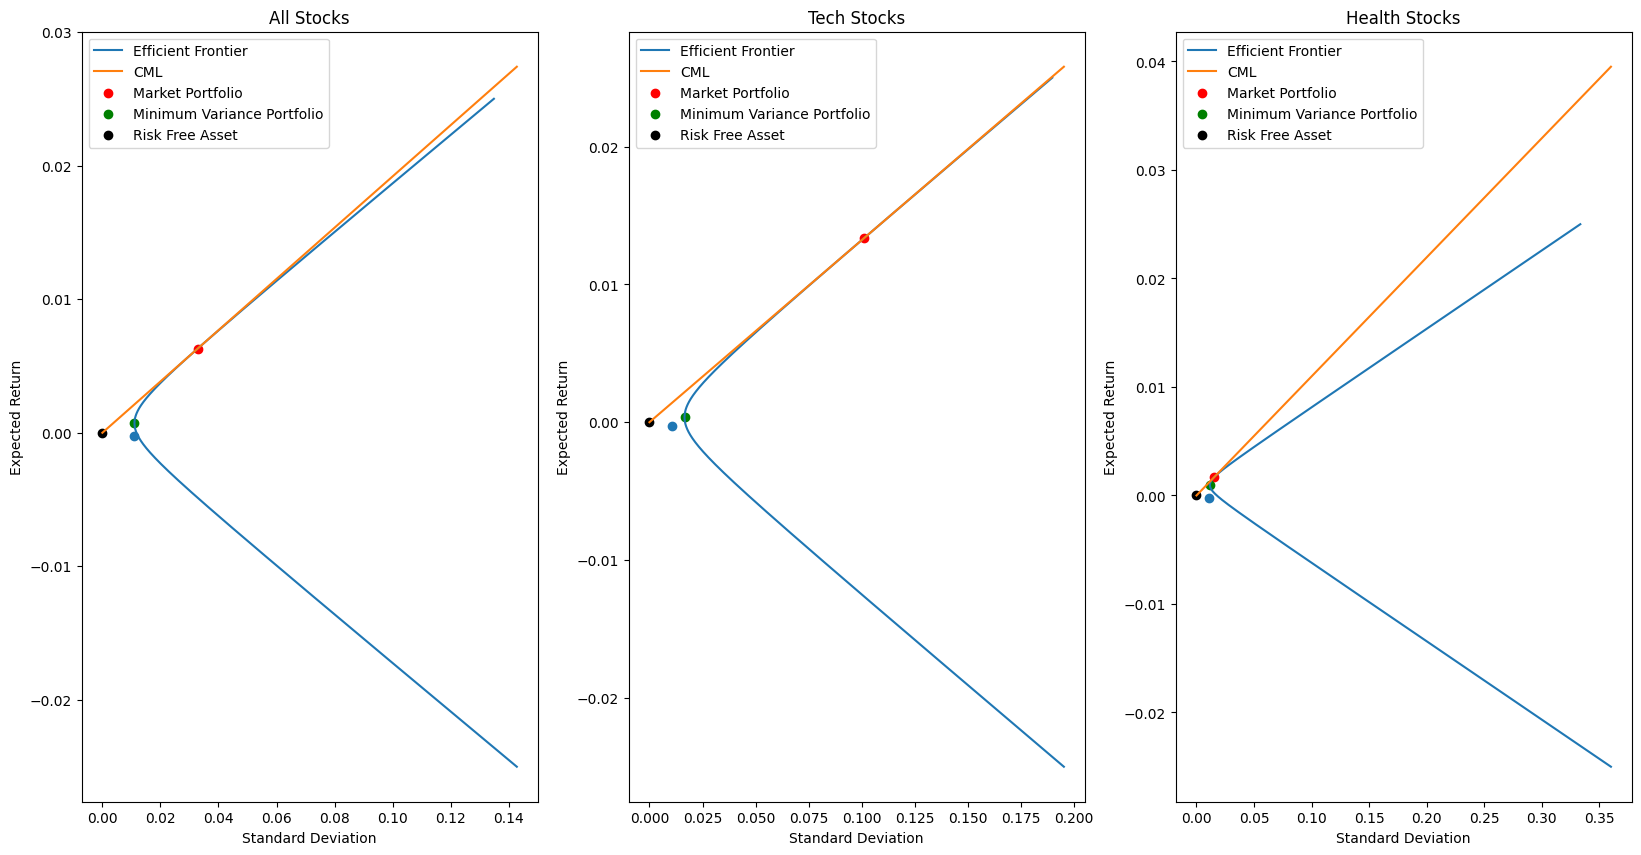

In [38]:
# Now Let's Make the Graphs
import matplotlib as plt
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))
all_ticks = {'All': tech_ticks + health_ticks, 'Tech': tech_ticks, 'Health': health_ticks}



for i, ticks in enumerate(all_ticks):
    
    ax = fig.add_subplot(1,3,i+1)
    sigma_ef, mu_ef = fsp_toolkit.calcEfficientFrontier(stocks, all_ticks[ticks], start=-0.025, stop=0.025, step=2000)
    WMVP, SMVP, UMVP =fsp_toolkit.calcMVP(stocks, all_ticks[ticks])
    WMP, SMP, UMP =fsp_toolkit.calcMP(stocks, all_ticks[ticks])

    print("The MVP lies on the point (", round(SMVP,6),",", round(UMVP,6),")", "and the MP lies on the point (", round(SMP,6),",", round(UMP,6),")")

    m_ex = stocks[all_ticks[ticks]].describe(percentiles=[]).loc['mean']
    weights_show = pd.DataFrame([WMVP, WMP ,m_ex], columns=all_ticks[ticks], index=['Weight of the Min Variance Portfolio','Weight of the Market Portfolio', 'Mean Expected Returns'])
    display(weights_show.head(3))

    fsp_toolkit.plotEfficientFrontier((sigma_ef, mu_ef), (SMP,UMP), (SMVP, UMVP), ax=ax)
    ax.scatter(sp500_sigma, sp500_mu)
    ax.title.set_text(ticks + ' Stocks')

plt.show()

Looking at the weights of the MP, there is significant short selling; This would mean that an SP would likely be a bad measure (expect for possibly the Health Sector). Additionally, the rate of return for the S&P500 is below the rf rate, which by construction the MP must be greater than.

In [39]:
# Compute the B for each individual stock relative to the MP of the full set, and again relative to the MP of the sector subset. 


for i, subset in enumerate(all_ticks):
    print("Relative to the " + subset + " stocks:")

    WMP, SMP, UMP =fsp_toolkit.calcMP(stocks, all_ticks[subset])
    stocks['MP'] = WMP @ stocks[all_ticks[subset]].T

    beta, alpha, residuals= fsp_toolkit.singleFactorModel(stocks, X='MP', Y=all_ticks[subset])
    display(pd.DataFrame([alpha, beta], index=['alpha', 'beta'], columns=all_ticks[subset]))

    
    
    



Relative to the All stocks:


,NVDA,GOOGL,AMZN,META,MSFT,ILMN,PFE,HCA,ABMD,ISRG
alpha,-1.301043e-18,-8.876905e-19,1.301043e-18,-1.626303e-18,-9.757820e-19,2.168404e-19,-5.421011e-19,-1.517883e-18,-2.168404e-18,2.168404e-19
beta,-1.687798e-01,7.770385e-03,1.873950e-01,-1.532050e-01,1.217256e-01,2.308525e-01,1.184443e-01,2.294022e-01,4.089036e-01,1.949538e-01


Relative to the Tech stocks:


,NVDA,GOOGL,AMZN,META,MSFT
alpha,0.000000,-8.470329e-19,0.00000,6.505213e-19,-1.626303e-18
beta,-0.079538,3.661800e-03,0.08831,-7.219796e-02,5.736330e-02


Relative to the Health stocks:


,ILMN,PFE,HCA,ABMD,ISRG
alpha,6.505213e-19,-1.084202e-19,2.168404e-19,-4.336809e-19,6.505213e-19
beta,8.588616e-01,4.406591e-01,8.534661e-01,1.521282e+00,7.253046e-01


# Question 2

/tmp/ipykernel_1048/1971226583.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks_jan.loc[:, ('MP_tech')] = list(w_tech @ stocks_jan[tech_ticks].T)
/tmp/ipykernel_1048/1971226583.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks_jan.loc[:, ('MP_health')] = list(w_health @ stocks_jan[health_ticks].T)
/tmp/ipykernel_1048/1971226583.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

,NVDA,GOOGL,AMZN,META,MSFT,ILMN,PFE,HCA,ABMD,ISRG,MP_tech,MP_health,MP_all
beta,1.014820,0.614634,0.819634,0.560702,0.689997,0.858862,0.440659,0.853466,1.521282,0.725305,NaN,NaN,NaN
mean,-0.000263,-0.003347,0.002401,-0.002235,-0.000481,-0.000820,-0.000926,-0.000928,0.007452,-0.000479,0.003783,0.005183,0.00977


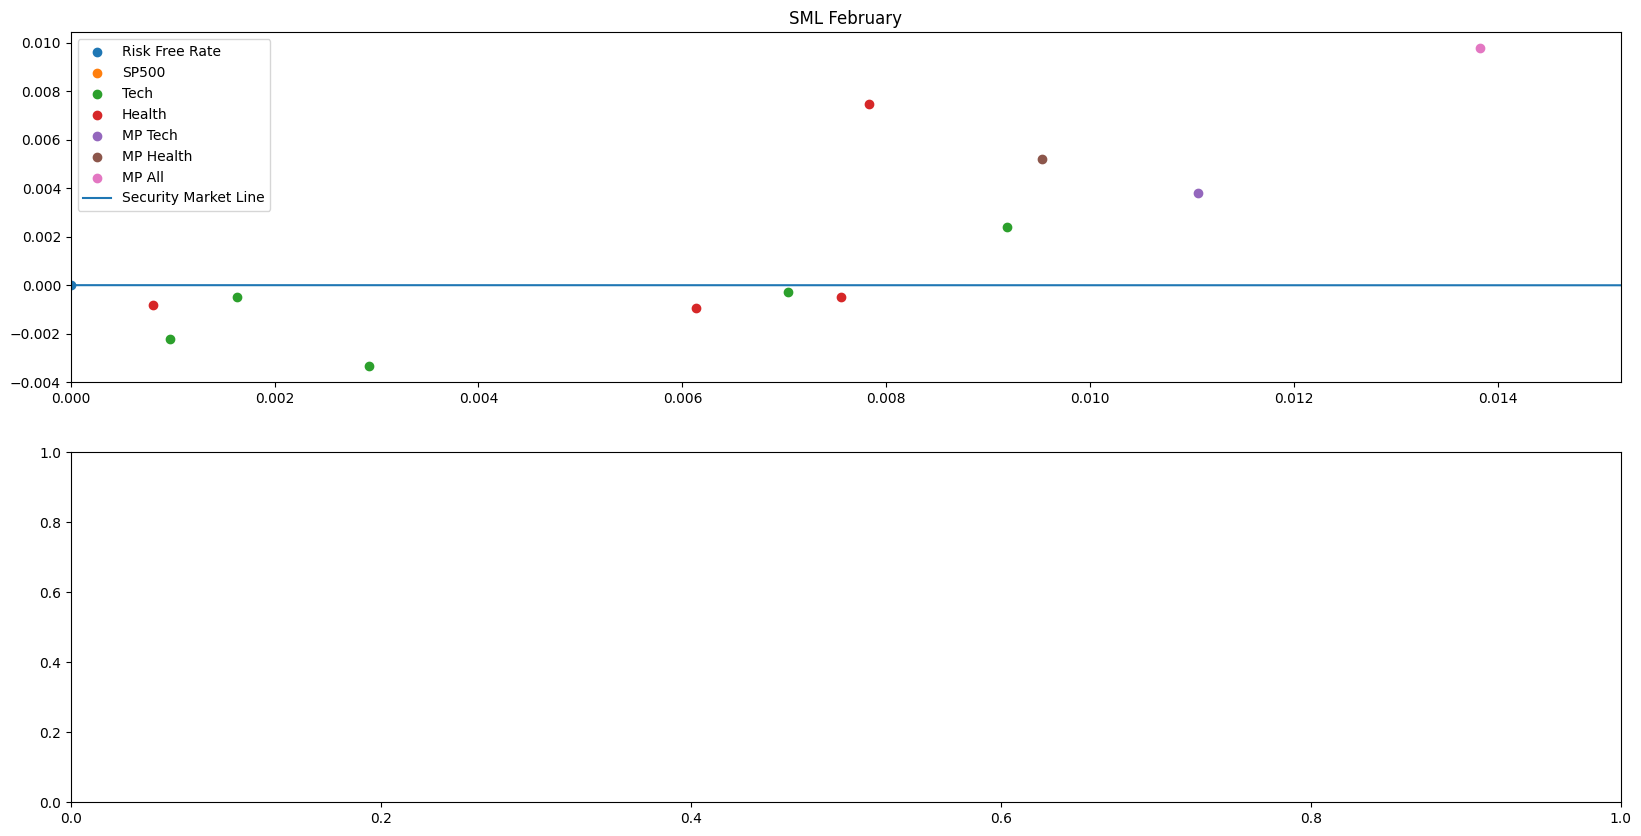

In [40]:
stocks_jan = stocks.loc[stocks.index.month == 1]
stocks_feb = stocks.loc[stocks.index.month == 2]

ticks = all_ticks['All']

fig = plt.figure(figsize=(20, 10))

# Compute the B for each stock relative to the SP500 in January and February

w_tech, _, _ = fsp_toolkit.calcMP(stocks_jan, tech_ticks)
w_health, _, _ = fsp_toolkit.calcMP(stocks_jan, health_ticks)
w_all, _, _ = fsp_toolkit.calcMP(stocks_jan, ticks)

stocks_jan.loc[:, ('MP_tech')] = list(w_tech @ stocks_jan[tech_ticks].T)
stocks_jan.loc[:, ('MP_health')] = list(w_health @ stocks_jan[health_ticks].T)
stocks_jan.loc[:, ('MP_all')] = list(w_all @ stocks_jan[ticks].T)


_, beta_j, _= fsp_toolkit.singleFactorModel(stocks_jan, X='^GSPC', Y=ticks + ['MP_tech', 'MP_health', 'MP_all'])

stocks_feb.loc[:, ('MP_tech')] = list(w_tech @ stocks_feb[tech_ticks].T)
stocks_feb.loc[:, ('MP_health')] = list(w_health @ stocks_feb[health_ticks].T)
stocks_feb.loc[:, ('MP_all')] = list(w_all @ stocks_feb[ticks].T)

f_mean = stocks_feb.describe(percentiles=[]).loc['mean']
display(pd.DataFrame([beta, f_mean], index=['beta', 'mean'], columns=ticks + ['MP_tech', 'MP_health', 'MP_all']))

# Obtain the security market line for the January and February periods
ax = fig.add_subplot(2,1,1)
ax.title.set_text('SML February')

ax.scatter(0,0, label='Risk Free Rate')
ax.scatter(1, sp500_mu, label='SP500')
ax.scatter(beta_j[all_ticks['Tech']], f_mean[all_ticks['Tech']], label='Tech')
ax.scatter(beta_j[all_ticks['Health']], f_mean[all_ticks['Health']], label='Health')
ax.scatter(beta_j['MP_tech'], f_mean['MP_tech'], label='MP Tech')
ax.scatter(beta_j['MP_health'], f_mean['MP_health'], label='MP Health')
ax.scatter(beta_j['MP_all'], f_mean['MP_all'], label='MP All')
ax.plot([0,1], [0, sp500_mu], label='Security Market Line')

ax2 = fig.add_subplot(2,1,2)
ax2 = ax
ax2.set_xlim(0, 1.1*max(beta_j))


ax.legend()


/home/jacob/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


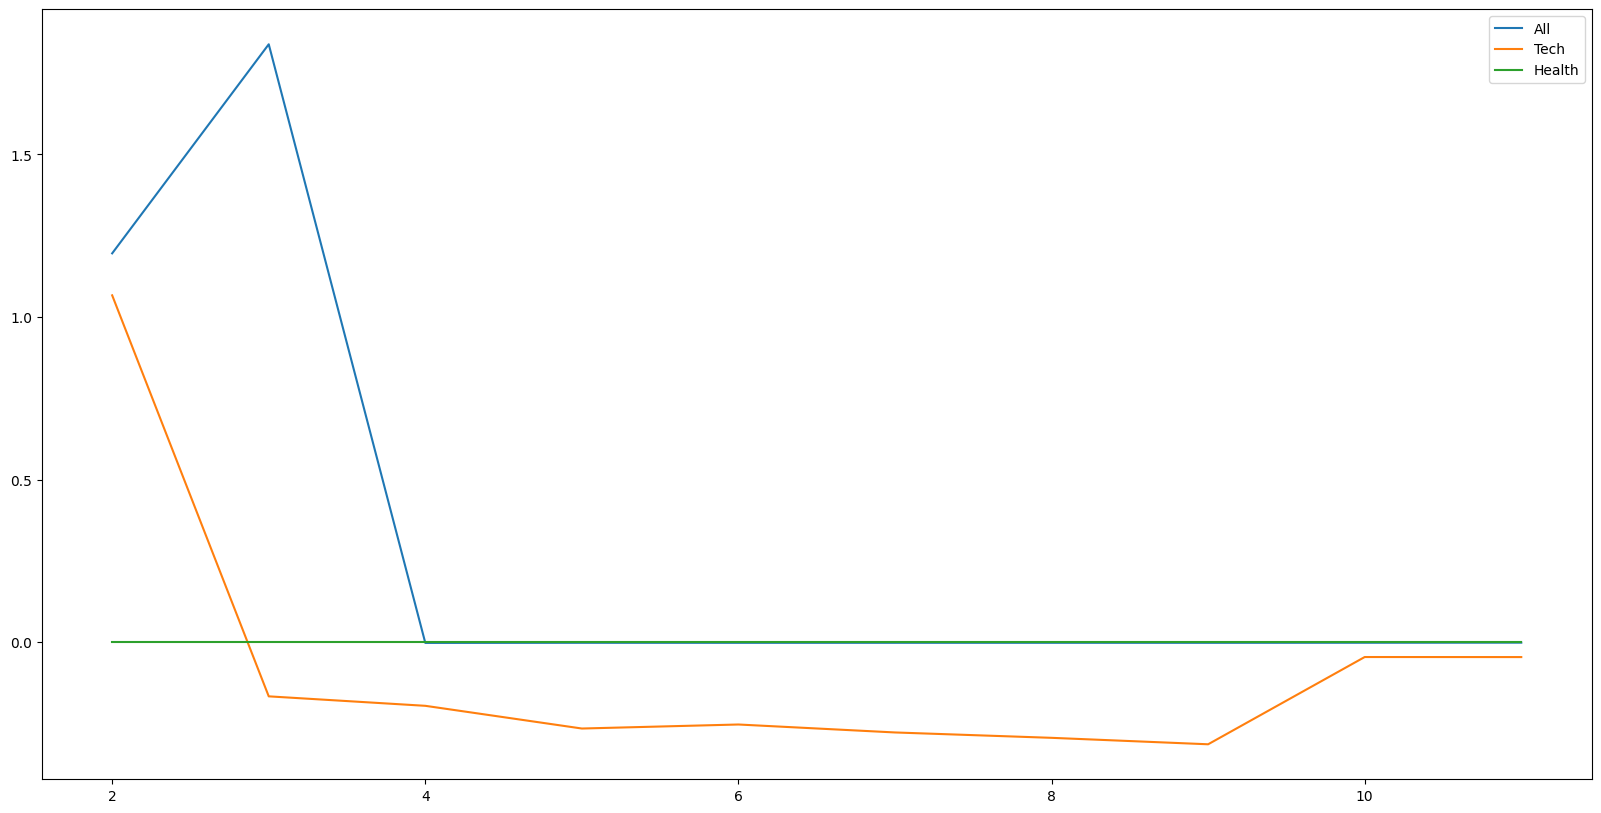

In [41]:
# Each Month, take the value of last month's portfolio and rebalanced it to the M
# print("ALL")

all_value = []
value = 1
for month in range(2,12):
    stocks_month = stocks.loc[stocks.index.month == month - 1]
    stocks_month_next = stocks.loc[stocks.index.month == month]
    WMP, SMP, UMP =fsp_toolkit.calcMP(stocks_month, all_ticks['All'])
    # print(value, "rate: ", (np.product((WMP @ stocks_month_next[all_ticks['All']].T).values + 1)))
    value = value * (np.product((WMP @ stocks_month_next[all_ticks['All']].T).values + 1))
    all_value.append(value)


tech_values = []
# print("TECH")
value = 1
for month in range(2,12):
    stocks_month = stocks.loc[stocks.index.month == month - 1]
    stocks_month_next = stocks.loc[stocks.index.month == month]
    WMP, SMP, UMP =fsp_toolkit.calcMP(stocks_month, all_ticks['Tech'])
    # print(value, "rate: ", (np.product((WMP @ stocks_month_next[all_ticks['Tech']].T).values + 1)))
    value = value * (np.product((WMP @ stocks_month_next[all_ticks['Tech']].T).values + 1))
    tech_values.append(value)

health_values = []
# print("HEALTH")
value = 1j
for month in range(2,12):
    stocks_month = stocks.loc[stocks.index.month == month - 1]
    stocks_month_next = stocks.loc[stocks.index.month == month]
    WMP, SMP, UMP =fsp_toolkit.calcMP(stocks_month, all_ticks['Health'])
    # print(value, "rate: ", (np.product((WMP @ stocks_month_next[all_ticks['Health']].T).values + 1)))
    value = value * (np.product((WMP @ stocks_month_next[all_ticks['Health']].T).values + 1))
    health_values.append(value)


plt.figure(figsize=(20,10))
plt.plot(range(2,12), all_value, label='All')
plt.plot(range(2,12), tech_values, label='Tech')
plt.plot(range(2,12), health_values, label='Health')
plt.legend()
    